## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output](#read)


* [Running factorisation to identify groups of co-located cell types / tissue compartments](#factorisation)
* [Running factorisation including the composition of neighbouring spots](#factorisation_with_neighbours)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


### Reading cell2location model output <a class="anchor" id="read"></a>

In [2]:
# read cell2location model results
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/visium_human_ln/'

run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

fig_path = results_folder + 'std_model/'+run_name+'/plots/'

sp_data_file = results_folder + 'std_model/'+run_name+'/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


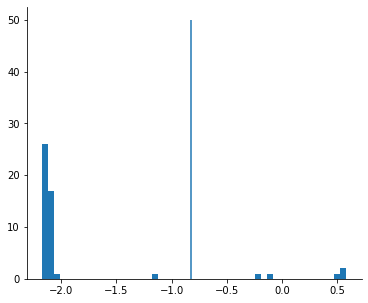

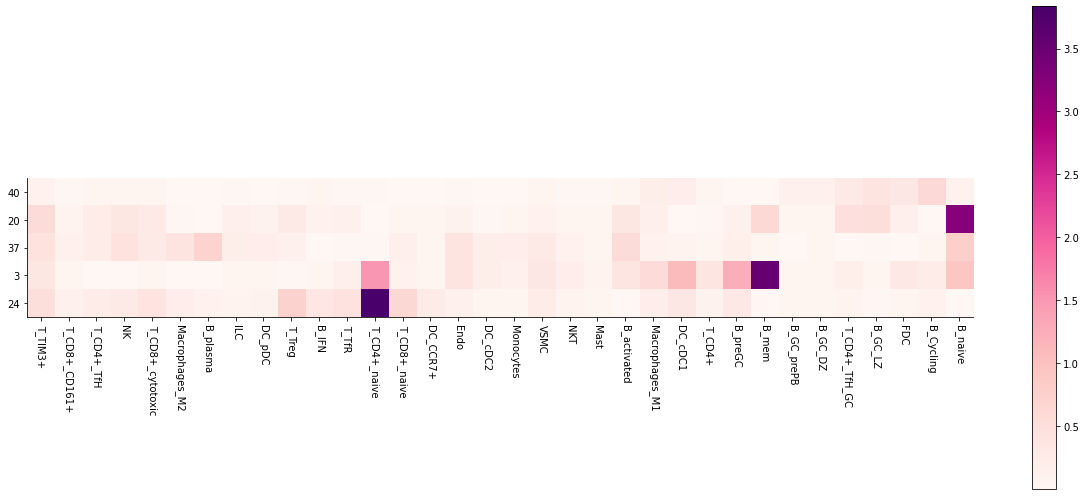

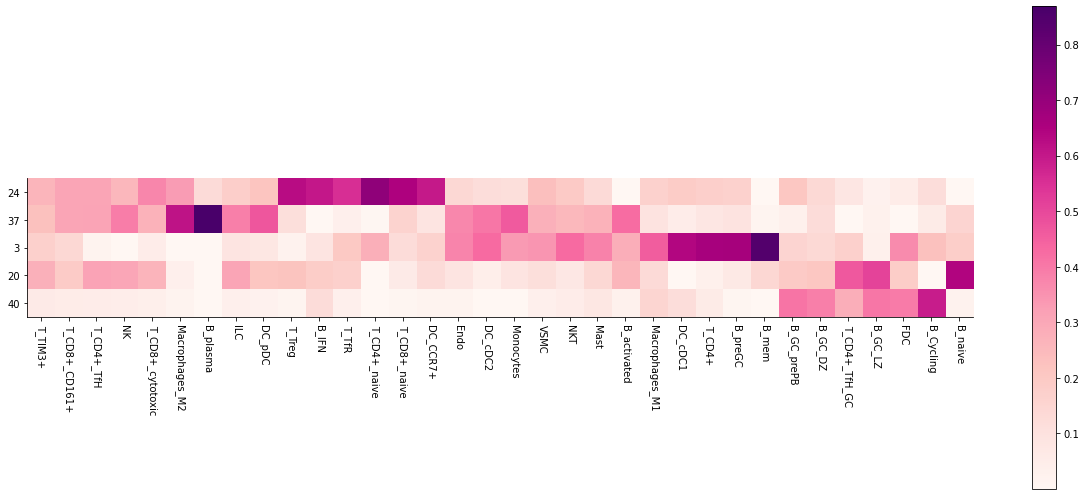

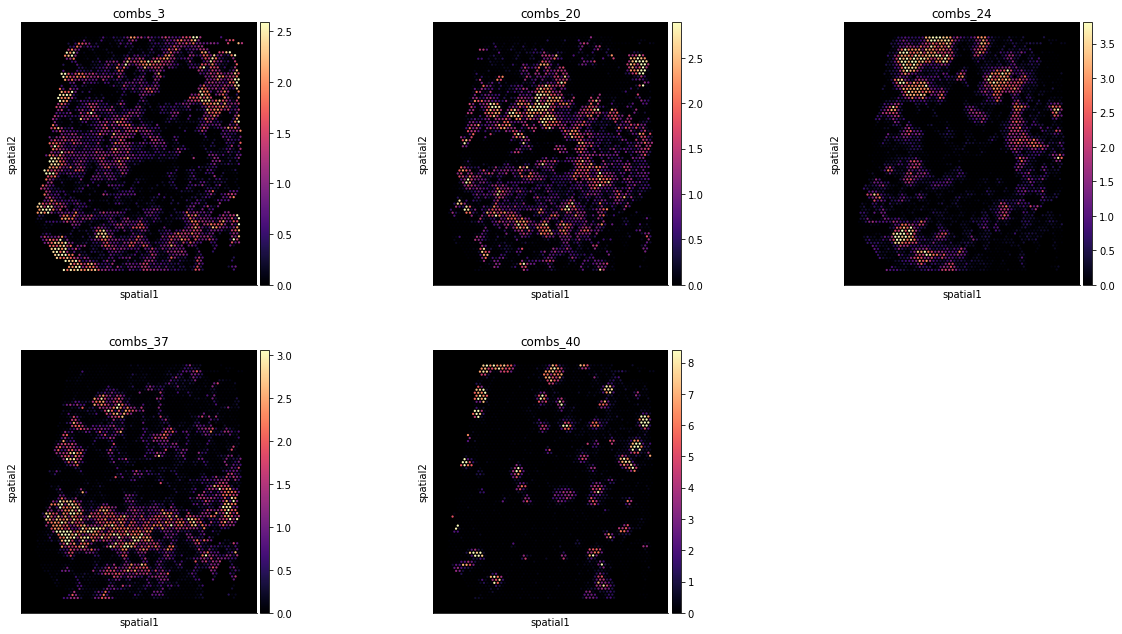

In [3]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis.uns['mod']['fact_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.15
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['combs_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['combs_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors


s = 'V1_Human_Lymph_Node'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(adata_vis[adata_vis.obs['sample'].isin([s]),:], cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

### Running factorisation to identify archetypal tissue compartments <a class="anchor" id="factorisation"></a>

In [6]:
from cell2location import run_colocation
res_dict, sp_data = run_colocation(
                   adata_vis, model_name='ArchetypalAnalysis',
                   verbose=False, return_all=True,
    
                   train_args={'n_fact': np.arange(8, 28), 'n_iter': 20000,
                    'sample_name_col': 'sample',
                    'mode': 'normal', 'n_type': 'restart', 'n_restarts': 5},
    
                   model_kwargs={'pcha_kwd_args': {'conv_crit': 1e-06}},
    
                   posterior_args={},
                   export_args={'path': results_folder + 'std_model/'+run_name+'/CoLocatedComb/',
                                'run_name_suffix': ''})

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: ArchetypalAnalysis_8combinations_4039locations_34factors


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_9combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_10combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_11combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_12combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_13combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_14combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_15combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_16combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_17combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_18combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_19combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_20combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_21combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_22combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_23combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_24combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_25combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_26combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


### Analysis name: ArchetypalAnalysis_27combinations_4039locations_34factors


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'sample' as categorical


/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample' as categorical


TypeError: Scalar datasets don't support chunk/filter options

Above error raised while writing key 'uns/mod_coloc_n_fact8/post_sample_means/SSE' of <class 'h5py._hl.files.File'> from /.

In [ ]:
! ~/gdrive upload --parent 1um1BialWJqy-s2GURKf8Ij5NmjnMqMkP --recursive /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/visium_human_ln/std_model/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/CoLocatedComb/ArchetypalAnalysis_4039locations_34factors